In [2]:
# Random Forest Model
import numpy as np 
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
os.getcwd()
train = pd.read_csv("training_data.csv")
# test = pd.read_csv("test_data.csv") # no response value, need to be added later
# print(train)
# type(train)
# type(test)

In [6]:
# To find how many values are null in which column
NAs = pd.concat([train.isnull().sum()], axis = 1, keys = ["Train"])
NAs[NAs.sum(axis=1)>0]

,Train


In [8]:
# Convert qualitative predictors to dummy variables
for col in train.dtypes[train.dtypes == "object"].index:
    for_dummy = train.pop(col)
    train = pd.concat([train,pd.get_dummies(for_dummy,prefix=col)],axis = 1)
    # print(col)
    
train.head()

,Camera_Id,Vehicle_Count,Density,Average_Speed,Latitude,Longitude,Is_Weekday,Is_Peak,Jam,Direction_AIRPORT,...,Time_23:10:41,Time_23:10:42,Time_23:10:43,Time_23:10:44,Time_23:10:45,Time_23:10:46,Time_23:10:48,Time_23:10:49,Time_23:10:50,Time_23:10:51
0,1503,0,0.00,24.5,1.270664,103.856978,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1503,0,0.00,24.5,1.270664,103.856978,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4709,0,0.00,100.0,1.312019,103.763002,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4709,0,0.00,100.0,1.312019,103.763002,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2703,7,0.07,100.0,1.350478,103.791034,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# extract response variabels 
labels = train.pop("Jam")

In [10]:
# split dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.25)

In [19]:
# Begin Random Forest modelling
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train) # trained model

RandomForestClassifier()

In [20]:
# Predicted response from validation dataset
y_pred = rf.predict(x_test)
y_pred

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1])

In [21]:
# Checking for accuracy
from sklearn.metrics import roc_curve, auc
false_positive_rate,true_positive_rate, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(false_positive_rate,true_positive_rate)
roc_auc
# roc_auc = area under curve, the closer it is to 1 the more accurate the model

0.9132572777340677

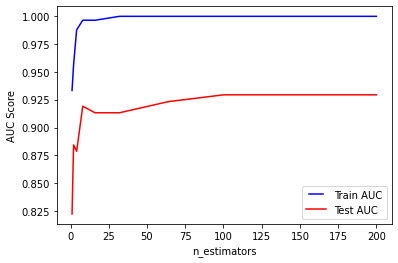

In [18]:
# Finding the right estimator size for boostrapping
n_estimators = [1,2,4,8,16,32,64,100,200]
train_results = []
test_results = [] 
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators = estimator, n_jobs=-1)
    rf.fit(x_train,y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate , thresholds =roc_curve(y_train,train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred =rf.predict(x_test)
    false_positive_rate, true_positive_rate , thresholds =roc_curve(y_test,y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators,train_results, "b", label = "Train AUC")
line2, = plt.plot(n_estimators,test_results, "r", label = "Test AUC")
plt.legend(handler_map={line1:HandlerLine2D(numpoints =2)})
plt.ylabel("AUC Score")
plt.xlabel("n_estimators")
plt.show()

index = test_results.index(min(test_results))
best_n = n_estimators[index]
print(best_n)

# From the graph, we can see that the best model iterations is when n=32
# need to retrain and include n_estimators to be 32 when i instantiate RandomForestClassifier 

In [ ]:
# Retraining of model with n_estimators of highest AUC Score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = best_n)

In [54]:
# Fitting the whole training dataset into the model 
rf.fit(train,labels) # use this model to predict income test dataset 
test_pred = rf.predict(test)

# Adding the newly predicted output to the test_data under a new column called Jam
test["Jam"] = test_pred
test.to_csv("test_data.csv") # now the test_data will have the response variables 